In [1]:
import openai
openai.api_key = 'your key'  
model_name = 'gpt-3.5-turbo'#'text-davinci-002' # CaP uses text-davinci-002

class ChatGPT():
    def __init__ (self, system_prompt, model_engine='text-davinci-003'):
        self.model_engine = model_engine
        self.system_prompt = system_prompt
        self.msg_history_davinci = self.system_prompt
        self.msg_history_turbo = [{"role": "assistant", "content": self.system_prompt}]
        self.role = 'user'
    
    def reset(self):
        self.msg_history_turbo = [{"role": "assistant", "content": self.system_prompt}]

    def get_answer(self, prompt=None):
        if self.model_engine == 'gpt-3.5-turbo':
            self.msg_history_turbo.append({"role": self.role, "content":prompt})
            response   = openai.ChatCompletion.create(
            model      = self.model_engine,
            temperature= 0.0,
            messages   = self.msg_history_turbo)
            reply_text = response['choices'][0]['message']['content']
            self.msg_history_turbo.append({"role":"assistant", "content":reply_text})

        elif self.model_engine == 'text-davinci-003': 
            self.msg_history_davinci += "You: "+prompt 
            response   = openai.Completion.create(
            engine     = self.model_engine,
            prompt     = self.msg_history_davinci,
            max_tokens = 512,
            temperature= 1.0,
            n          = 1,
            #stop       = ["You:", "AI:"]
            )
            reply_text = response.choices[0].text.strip().replace('Answer: ', '')
            self.msg_history_davinci+="\n"+"AI: "+reply_text+"\n"

        elif self.model_engine == 'text-davinci-002': 
            response   = openai.Completion.create(
            engine     = self.model_engine,
            prompt     = prompt,
            max_tokens = 512,
            temperature= 1.0,
            n          = 1,
            )
            reply_text = response['choices'][0]['text'].strip()
        return reply_text



In [2]:
sys_prompt = """
We have a manipulator and we want you to help plan how it should move to perform tasks using the
following APIs:
    def end_effector_to(position_obj)
position_obj is a list of 3 float numbers [x,y,z]
    def end_effector_open()
Open the end effector
    def get_object_center_position(obj_name)
Given an object name, return a list of 3 float numbers [x,y,z] for the object position.
    def get_object_size(obj_name)
Given an object name, return a list of 3 float numbers [x,y,z] for the object size.
    def get_current_position()
Return a list of 3 float numbers [x,y,z] for the current position of the end effector.
    def normalize_table_position(position_obj)
Given a position, return a normalized position that is on the table.
    def denormalize_table_position(position_obj)
Given a normalized position, return a position that is on the table.
    def check_empty(position_obj)
Return True if the position is empty, False otherwise.

Example answer code:
    import numpy as np
    # place the object in the tray
    object_pos = get_object_center_position('tray')
    object_size = get_object_size('tray')
    range_y = [object_pos[1] - object_size[1] + 0.05 , object_pos[1] + object_size[1]-0.05]
    for y in np.linspace(range_y[0], range_y[1], 10):
        target_pos = [object_pos[0], y, object_pos[2]+0.08]
        empty = check_empty(target_pos)
        if empty:
            end_effector_to(target_pos)
            end_effector_open()
            break

    # place the object in the tray_gray
    object_pos = get_object_center_position('tray_gray')
    object_size = get_object_size('tray_gray')
    range_y = [object_pos[1] - object_size[1] + 0.05 , object_pos[1] + object_size[1]-0.05]
    for y in np.linspace(range_y[0], range_y[1], 10):
        target_pos = [object_pos[0], y, object_pos[2]+0.08]
        empty = check_empty(target_pos)
        if empty:
            end_effector_to(target_pos)
            end_effector_open()
            break

    # place the object in the blue_bowl
    object_pos = get_object_center_position('kitchen_blue_bowl')
    object_size = get_object_size('kitchen_blue_bowl')
    range_y = [object_pos[1] - object_size[1] + 0.05 , object_pos[1] + object_size[1] - 0.05]
    for y in np.linspace(range_y[0], range_y[1], 10):
        target_pos = [object_pos[0], y, object_pos[2]+0.08]
        empty = check_empty(target_pos)
        if empty:
            end_effector_to(target_pos)
            end_effector_open()
            break
                        
    # place the object on the center of the table
    target_pos = [0, 0, 0]
    target_pos = denormalize_table_position(target_pos)
    end_effector_to(target_pos)
    end_effector_open()

Remember:
1. Always format the code in code blocks.
2. Do not invent new functions or classes. The only allowed functions you can call are the ones listed
above. Do not leave unimplemented code blocks in your response.
3. The only allowed library is numpy. Do not import or use any other library.
4. If you are not sure what value to use, just use your best judge. Do not use None for anything.
5. You do not need to make the robot do extra things not mentioned in the plan such as stopping the
robot.
6. Try your best to generate code despite the lack of context.
"""
llm = ChatGPT(sys_prompt, model_engine=model_name)
llm.reset()


In [3]:
import mujoco#,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../')
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r,r2rpy,r2quat,compute_view_params,get_interp_const_vel_traj, printmd
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


In [4]:
print ("MuJoCo version:[%s]"%(mujoco.__version__))
xml_path = '../../../asset/visualize_realworld_wo_shelf_pringles.xml'
env = MuJoCoParserClass(name='Place task scene: Office table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('base').pos = np.array([0.18,0,0.79])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-0.05,0.80,0])

# Place objects
tray_pos = np.array([ 0.9, 0.25, 0.8])
tray_gray_pos = np.array([ 0.9, 0., 0.8])
bowl_red_pos = np.array([ 0.9, -0.25, 0.8])
env.model.joint(env.model.body('tray').jntadr[0]).qpos0[:3] = tray_pos
env.model.joint(env.model.body('tray').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([90, 0, 90])))
env.model.joint(env.model.body('tray_gray').jntadr[0]).qpos0[:3] = tray_gray_pos
env.model.joint(env.model.body('tray_gray').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([90, 0, 90])))
env.model.joint(env.model.body('kitchen-bowl-red').jntadr[0]).qpos0[:3] = bowl_red_pos

env.model.joint(env.model.body('ycb-apple-2').jntadr[0]).qpos0[:3] = bowl_red_pos + np.array([0,0,0.1])
env.model.joint(env.model.body('mug_cup').jntadr[0]).qpos0[:3] = tray_pos + np.array([0.05,0,0.05])
env.model.joint(env.model.body('hershey_cookie').jntadr[0]).qpos0[:3] = tray_gray_pos + np.array([0.05,0,0.05])
env.model.joint(env.model.body('hershey_cookie').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([90, -90, 0])))

env.model.joint(env.model.body('kitchen-bowl-blue').jntadr[0]).qpos0[:3] = np.array([-5,0,0.5])
env.model.joint(env.model.body('ycb-banana-2').jntadr[0]).qpos0[:3] = np.array([-9,0,0]) # sorted_pose[2] + spawn_z_offset
env.model.joint(env.model.body('ycb-lemon-2').jntadr[0]).qpos0[:3] = np.array([-5,0,0.5])
env.model.joint(env.model.body('ycb-orange-2').jntadr[0]).qpos0[:3] = np.array([-5,0,0.5])

# Target objects
env.model.joint(env.model.body('pringles').jntadr[0]).qpos0[:3] = np.array([0.1, -0.6, 0.8])

MuJoCo version:[2.3.7]
window


In [5]:
object_info_dict = dict()
tray_size = [0.11, 0.15, 0.01]
tray_gray_size = [0.11, 0.15, 0.01]
apple_size = [0.04, 0.04, 0.04]
hershey_cookie_size = [0.15, 0.05, 0.07]
glass_size = [0.03, 0.03, 0.07]
table_size   = env.model.geom_aabb[env.model.body('avoiding_object_table').geomadr][0][3:]

object_info_dict['avoiding_object_table'] = {'name':"table", 'size': table_size, 'position': [0.38+0.45, 0., 0.8], 'rotation':[0., 0., 0.]}


In [6]:
import math
def quat2r(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
        return roll_x, pitch_y, yaw_z

In [7]:
object_info_dict = dict()
tray_size = [0.11, 0.15, 0.01]
tray_gray_size = [0.11, 0.15, 0.01]
apple_size = [0.04, 0.04, 0.04]
hershey_cookie_size = [0.15, 0.05, 0.07]
glass_size = [0.03, 0.03, 0.07]
table_size   = env.model.geom_aabb[env.model.body('avoiding_object_table').geomadr][0][3:]

object_info_dict['avoiding_object_table'] = {'name':"table", 'size': table_size, 'position': [0.38+0.45, 0., 0.8], 'rotation':[0., 0., 0.]}


In [8]:
from utils.util import r2quat

seen_obj_names = []
for body_name in env.body_names:
    if 'mug' in body_name:
        seen_obj_names.append(body_name)
        object_info_dict[body_name] = {'name':"mug", 'size': glass_size, 'position': env.get_p_body(body_name), 'rotation': env.get_R_body(body_name)}
    elif 'hershey' in body_name:
        seen_obj_names.append(body_name)
        object_info_dict[body_name] = {'name':"hershey", 'size': hershey_cookie_size, 'position': env.get_p_body(body_name), 'rotation':env.get_R_body(body_name)}
    elif 'tray' in body_name:
        seen_obj_names.append(body_name)
        object_info_dict[body_name] = {'name':"tray", 'size': tray_size, 'position': env.get_p_body(body_name), 'rotation':env.get_R_body(body_name)}
    elif 'apple' in body_name:
        seen_obj_names.append(body_name)
        object_info_dict[body_name] = {'name':"apple", 'size': apple_size, 'position': env.get_p_body(body_name), 'rotation':env.get_R_body(body_name)}


In [9]:
object_lst = ['base_table', 'avoiding_object_table',
              'tray_gray','tray','mug_cup',
              'hershey_cookie', 'ycb-apple-2']
for object_name in object_lst:
    p_obj,R_obj = env.get_pR_body(body_name=object_name)
    print("Name: {} / Position:{} / RPY: {}".format(object_name, p_obj, r2rpy(R_obj)))


Name: base_table / Position:[0. 0. 0.] / RPY: [ 0. -0.  0.]
Name: avoiding_object_table / Position:[0.83 0.   0.  ] / RPY: [ 0. -0.  0.]
Name: tray_gray / Position:[ 0.8 -0.4  1.2] / RPY: [1.57 0.   1.57]
Name: tray / Position:[ 0.8 -0.4  1.2] / RPY: [1.57 0.   1.57]
Name: mug_cup / Position:[1.  0.2 0.8] / RPY: [ 0. -0.  0.]
Name: hershey_cookie / Position:[ 1.  -0.3  2. ] / RPY: [ 0. -0.  0.]
Name: ycb-apple-2 / Position:[0. 0. 0.] / RPY: [ 0. -0.  0.]


In [10]:
seen_obj_names = []
for name in object_info_dict.values():
    seen_obj_names.append(name['name'])

## LLM

In [11]:
prompt = "# you are now holding a snack of 'pringles'. Place the 'pringles' on location that best fit with the same object property.\n"
prompt += "seen_objects = "+str(seen_obj_names)+"\n"
print(prompt)
code = llm.get_answer(prompt=prompt)

# you are now holding a snack of 'pringles'. Place the 'pringles' on location that best fit with the same object property.
seen_objects = ['table', 'tray', 'tray', 'hershey', 'mug', 'apple', 'apple']



In [12]:
print(code)

import numpy as np

# find the best location to place the 'pringles'
best_location = None
best_score = -1

for obj_name in seen_objects:
    if obj_name == 'table':
        continue
    
    object_pos = get_object_center_position(obj_name)
    object_size = get_object_size(obj_name)
    range_y = [object_pos[1] - object_size[1] + 0.05 , object_pos[1] + object_size[1]-0.05]
    
    for y in np.linspace(range_y[0], range_y[1], 10):
        target_pos = [object_pos[0], y, object_pos[2]+0.08]
        empty = check_empty(target_pos)
        
        if empty:
            # calculate the score for this location
            score = object_size[0] * object_size[1] * object_size[2]
            
            if score > best_score:
                best_score = score
                best_location = target_pos
                break

# place the 'pringles' on the best location
if best_location is not None:
    end_effector_to(best_location)
    end_effector_open()


In [13]:
'''
define functions
'''
def end_effector_to(position_obj):
    target_obj_name = 'pringles'
    target_obj_jntadr = env.model.body(target_obj_name).jntadr[0]
    target_obj_qposadr = env.model.jnt_qposadr[target_obj_jntadr]
    env.data.qpos[target_obj_qposadr:target_obj_qposadr+3] = position_obj
    # TODO check rotation here
    env.data.qpos[target_obj_qposadr+3:target_obj_qposadr+7] = r2quat(rpy2r(np.radians([0, 0, 0])))
    print("Move the end effector to {}".format(position_obj))
    #position_obj is a list of 3 float numbers [x,y,z]

def end_effector_open():
    #Open the end effector
    pass
def get_object_center_position(obj_name):
    #Given an object name, return a list of 3 float numbers [x,y,z] for the object position.
    for obj in object_info_dict:
        if object_info_dict[obj]['name'] == obj_name or obj == obj_name:
            return object_info_dict[obj]['position']
    
    print("Object {} not found".format(obj_name))
    current_pos = get_current_position()
    return current_pos
    
def get_object_size(obj_name):
    # Given an object name, return a list of 3 float numbers [x,y,z] for the object size.
    for obj in object_info_dict:
        if object_info_dict[obj]['name'] == obj_name or obj == obj_name:
            print("Object {} found".format(obj_name))
            return object_info_dict[obj]['size']
    return [0.0,0.0,0.0]  
def get_current_position():
    # Return a list of 3 float numbers [x,y,z] for the current position of the end effector.
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    return p_tcp

def normalize_table_position(position_obj):
    #Given a position, return a normalized position that is on the table.
    table_size = object_info_dict['avoiding_object_table']['size']#env.model.geom_aabb[env.model.body('base_table').geomadr][0][3:]
    table_pos =object_info_dict['avoiding_object_table']['position'] #env.model.body('base_table').pos
    normalized_pos = (position_obj - table_pos) / (table_size)
    return normalized_pos
def denormalize_table_position(position_obj):
    #Given a normalized position (0-1), return a position that is on the table.
    table_size = object_info_dict['avoiding_object_table']['size']#env.model.geom_aabb[env.model.body('base_table').geomadr][0][3:]
    table_pos =object_info_dict['avoiding_object_table']['position'] #env.model.body('base_table').pos
    denormalized_pos = position_obj * (table_size)+ table_pos
    denormalized_pos[0] = 0.5
    return denormalized_pos

def check_empty(position_obj):
    # Return True if the position is empty, False otherwise.
    for obj in object_info_dict:
        obj_pos = object_info_dict[obj]['position']
        obj_pos = np.array(obj_pos)
        if np.linalg.norm(obj_pos - position_obj) < 0.05:
            return False
    return True

In [14]:
code_in = "seen_objects = "+str(seen_obj_names)+"\n"
code_in += '\n' + code

In [15]:
printmd(code_in)

seen_objects = ['table', 'tray', 'tray', 'hershey', 'mug', 'apple', 'apple']

import numpy as np

# find the best location to place the 'pringles'
best_location = None
best_score = -1

for obj_name in seen_objects:
    if obj_name == 'table':
        continue
    
    object_pos = get_object_center_position(obj_name)
    object_size = get_object_size(obj_name)
    range_y = [object_pos[1] - object_size[1] + 0.05 , object_pos[1] + object_size[1]-0.05]
    
    for y in np.linspace(range_y[0], range_y[1], 10):
        target_pos = [object_pos[0], y, object_pos[2]+0.08]
        empty = check_empty(target_pos)
        
        if empty:
            # calculate the score for this location
            score = object_size[0] * object_size[1] * object_size[2]
            
            if score > best_score:
                best_score = score
                best_location = target_pos
                break

# place the 'pringles' on the best location
if best_location is not None:
    end_effector_to(best_location)
    end_effector_open()

## Excecute

Object tray found
Object tray found
Object hershey found
Object mug found
Object apple found
Object apple found
Move the end effector to [1.0, -0.3, 2.08]
[ 0.5  -0.01  1.16]
Pressed ESC
Quitting.


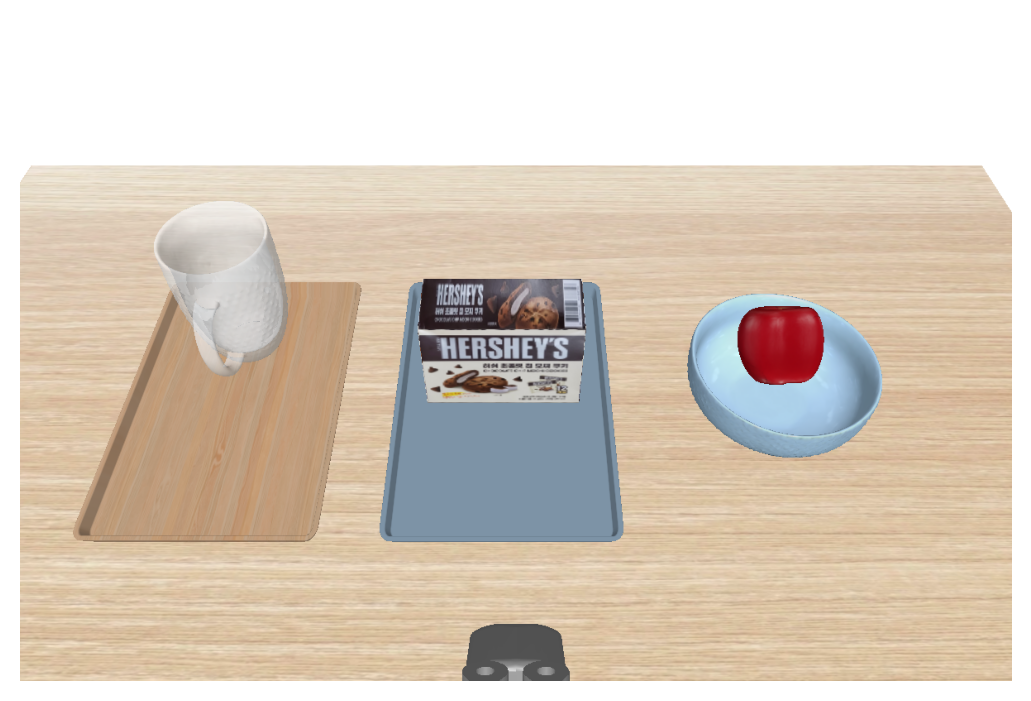

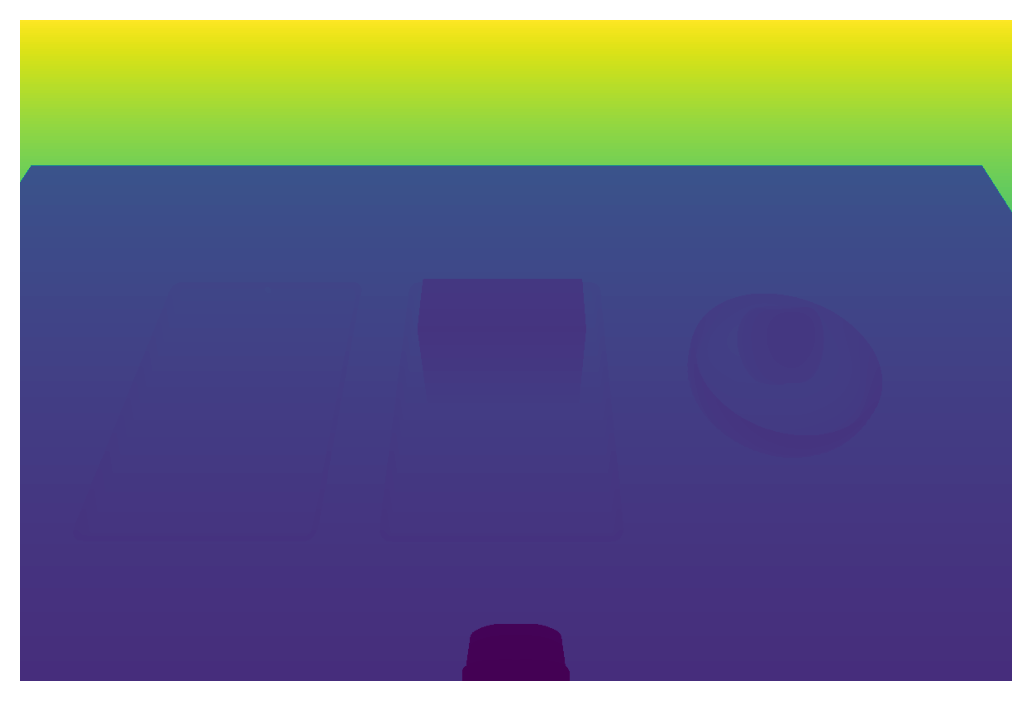

Done. Tick:[192] Time:[0.38]sec


In [16]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=30,distance=3.0,elevation=-30,lookat=[1.0,0.0,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0
env.reset()
exec(code_in)
init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))

tick,max_sec = 0,1000
while env.get_sim_time() <= max_sec:
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=200):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] + np.array([0,0,-0.1])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        env.render(render_every=1)

plt.imshow(rgb_img); plt.axis('off'); plt.show()
plt.imshow(depth_img); plt.axis('off'); plt.show()

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))